# Analisi i predicció dels accidents de transit a Barcelona 3

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from keras import optimizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint


## Loan files

In [3]:
from google.colab import files
uploaded = files.upload()

Saving df_clean_tipus_accidents.csv to df_clean_tipus_accidents (1).csv


In [5]:
import io
df_clean = pd.read_csv(io.BytesIO(uploaded['df_clean_tipus_accidents.csv']))
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_clean = df_clean[df_clean['Descripcio_victimitzacio']!='Mort']
df_clean 
    

,Codi_expedient,Descripcio_tipus_accident,NK_Any,Descripcio_tipus_persona,Descripcio_tipus_de_vehicle,Descripcio_victimitzacio,Edat,Codi_barri_x,Codi_carrer,Hora_dia,...,Codi_barri_y,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant
0,2017S001023,Col.lisió lateral,2017,Conductor,Motocicleta,Ferit lleu,33,64,209900,15,...,64,0.24280,16.3,56,0.0,2.2,4.0,1,0,0
1,2017S009198,Col.lisió fronto-lateral,2017,Conductor,Motocicleta,Ferit lleu,48,64,346402,14,...,64,0.13798,15.9,22,0.0,3.1,6.0,1,0,0
2,2017S006546,Abast,2017,Conductor,Motocicleta,Ferit lleu,47,64,297001,14,...,64,0.10725,28.5,57,0.0,3.8,7.3,1,0,0
3,2017S003698,Caiguda interior vehicle,2017,Passatger,Autobus,Ferit lleu,68,64,297001,20,...,64,0.01711,15.1,83,0.0,1.6,3.1,0,1,0
4,2017S004977,Abast,2017,Conductor,Motocicleta,Ferit lleu,41,64,297001,11,...,64,0.01015,18.9,67,0.0,2.2,6.0,1,0,0
5,2017S008080,Abast,2017,Conductor,Motocicleta,Ferit lleu,29,64,297001,19,...,64,0.01015,19.8,87,0.0,0.3,2.0,1,0,0
6,2017S004180,Abast,2017,Conductor,Motocicleta,Ferit lleu,32,64,105304,9,...,64,0.00711,14.0,96,0.0,1.0,2.5,1,0,0
7,2017S009138,Col.lisió fronto-lateral,2017,Passatger,Ciclomotor,Ferit lleu,26,64,289105,1,...,64,0.00247,15.2,82,0.0,3.2,7.4,0,1,0
8,2017S009138,Col.lisió fronto-lateral,2017,Conductor,Ciclomotor,Ferit lleu,40,64,289105,1,...,64,0.00247,15.2,82,0.0,3.2,7.4,1,0,0
9,2017S001925,Atropellament,2017,Conductor,Ciclomotor,Ferit lleu,19,64,350308,13,...,64,0.00287,17.0,58,0.0,2.7,4.9,1,0,0


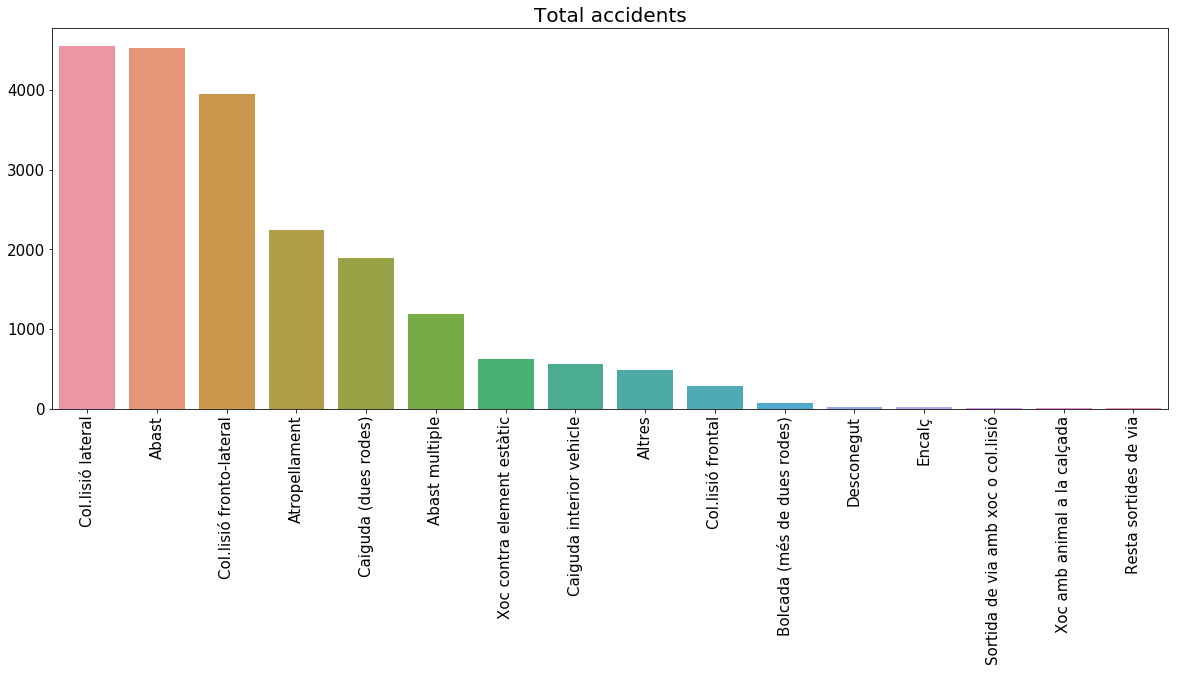

In [67]:

fig, ax2 = plt.subplots(figsize=(20,7))

sns.countplot(df_clean['Descripcio_tipus_accident'], ax=ax2, 
              order = df_clean['Descripcio_tipus_accident'].value_counts().index,
#               hue=df_clean['Descripcio_tipus_de_vehicle']
             )
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Total accidents', size=20)
ax2.tick_params(labelsize=15)
plt.xticks(rotation=90)
plt.show()

In [7]:
### Select the most common classes

select_colisions = df_clean['Descripcio_tipus_accident'].value_counts().iloc[:8].index
df_clean_colision = df_clean[df_clean["Descripcio_tipus_accident"].isin(select_colisions)]

df_clean_colision['Descripcio_tipus_accident'].unique()

array(['Col.lisió lateral', 'Col.lisió fronto-lateral', 'Abast',
       'Caiguda interior vehicle', 'Atropellament',
       'Caiguda (dues rodes)', 'Xoc contra element estàtic',
       'Abast multiple'], dtype=object)

## Data cleaning and prep

In [8]:
df_clean_colision=df_clean_colision[df_clean['Descripcio_tipus_accident']!='Desconegut']

# Labels are the values we want to predict
Y = df_clean_colision['Descripcio_tipus_accident'] 
Y = pd.get_dummies(Y)

# # Remove the labels from the features
# # axis 1 refers to the columns
X = df_clean_colision.drop(columns = ['Num_Greus', 'Num_Lleus', 'Num_Morts', 'Codi_expedient','Descripcio_victimitzacio',
                                     'Descripcio_tipus_persona','Descripcio_tipus_de_vehicle','Descripcio_tipus_accident'], axis = 1)
# Saving feature names for later use
feature_list = list(Y.columns)
num_columns = len(X.columns)
pd.set_option("display.max_columns", num_columns)
X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,NK_Any,Edat,Codi_barri_x,Codi_carrer,Hora_dia,Mes_any,Dia_mes,Longitud,Latitud,Num_Victimes,Num_Vehicles_Implicats,Poblacio,Nombre_vehicles_parc,Any,Sortida_Sol,Posta_Sol,Dif_PostaoSortida_Sol,Num_Semaf_Barri,Codi_barri_y,Dist_semaf,T,HR,PPT,VV10ESC,RVX10,Conductor,Passatger,Vianant
0,2017,33,64,209900,15,2,7,2.186591,41.415280,1,2,38371,9172,2017.0,7.0,18.0,3.0,2010,64,0.24280,16.3,56,0.0,2.2,4.0,1,0,0
1,2017,48,64,346402,14,11,7,2.184483,41.415436,1,2,38371,9172,2017.0,7.0,17.0,3.0,2010,64,0.13798,15.9,22,0.0,3.1,6.0,1,0,0
2,2017,47,64,297001,14,7,27,2.179666,41.415060,1,2,38371,9172,2017.0,6.0,21.0,7.0,2010,64,0.10725,28.5,57,0.0,3.8,7.3,1,0,0
3,2017,68,64,297001,20,4,25,2.177034,41.413077,1,1,38371,0,2017.0,6.0,20.0,0.0,2010,64,0.01711,15.1,83,0.0,1.6,3.1,0,1,0
4,2017,41,64,297001,11,6,7,2.176086,41.412368,1,2,38371,9172,2017.0,6.0,21.0,5.0,2010,64,0.01015,18.9,67,0.0,2.2,6.0,1,0,0
5,2017,29,64,297001,19,9,30,2.176086,41.412368,1,2,38371,9172,2017.0,7.0,19.0,0.0,2010,64,0.01015,19.8,87,0.0,0.3,2.0,1,0,0
6,2017,32,64,105304,9,5,11,2.177640,41.410550,1,2,38371,9172,2017.0,6.0,21.0,3.0,2010,64,0.00711,14.0,96,0.0,1.0,2.5,1,0,0
7,2017,26,64,289105,1,11,5,2.179003,41.409722,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,0,1,0
8,2017,40,64,289105,1,11,5,2.179003,41.409722,2,2,38371,2553,2017.0,7.0,17.0,6.0,2010,64,0.00247,15.2,82,0.0,3.2,7.4,1,0,0
9,2017,19,64,350308,13,3,9,2.184175,41.408507,2,1,38371,2553,2017.0,7.0,18.0,5.0,2010,64,0.00287,17.0,58,0.0,2.7,4.9,1,0,0


In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                Y, 
                                                train_size=0.75, 
                                                random_state = 42
                                               )
# Feature Scaling
sc = StandardScaler()  
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)  
Xtest = sc.transform(Xtest)  


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
# get shapes
N, D = Xtrain.shape
K = len(set(ytrain))

In [0]:
# the model will be a sequence of layers
model = Sequential()

model.add(Dense(units=128, input_dim=D))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.25))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=1024)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=128)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=K))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [69]:
fited_model = model.fit(Xtrain, ytrain, 
                        validation_data=(Xtest, ytest), 
                        epochs=50, 
                        batch_size=500)


Train on 14656 samples, validate on 4886 samples
Epoch 1/50
14656/14656 [==============================] - 13s 896us/step - loss: 2.1466 - acc: 0.1943 - val_loss: 1.7964 - val_acc: 0.3887
Epoch 2/50
14656/14656 [==============================] - 4s 304us/step - loss: 1.8228 - acc: 0.2980 - val_loss: 1.7103 - val_acc: 0.4059
Epoch 3/50
14656/14656 [==============================] - 4s 303us/step - loss: 1.7187 - acc: 0.3567 - val_loss: 1.6092 - val_acc: 0.4036
Epoch 4/50
14656/14656 [==============================] - 4s 302us/step - loss: 1.6458 - acc: 0.3977 - val_loss: 1.5431 - val_acc: 0.4300
Epoch 5/50
14656/14656 [==============================] - 4s 304us/step - loss: 1.5743 - acc: 0.4219 - val_loss: 1.4861 - val_acc: 0.4402
Epoch 6/50
14656/14656 [==============================] - 4s 304us/step - loss: 1.5128 - acc: 0.4365 - val_loss: 1.4459 - val_acc: 0.4527
Epoch 7/50
14656/14656 [==============================] - 4s 303us/step - loss: 1.4743 - acc: 0.4490 - val_loss: 1.4022 - 

In [70]:
loss, accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))
print('')
loss, accuracy = model.evaluate(Xtest, ytest, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.668668
Loss: 0.887480

Accuracy: 0.533565
Loss: 1.172141


In [71]:
from sklearn.metrics import classification_report
print(classification_report(ytest,model.predict(Xtest).round()))

              precision    recall  f1-score   support

           0       0.61      0.30      0.40      1146
           1       0.76      0.82      0.79       325
           2       0.91      0.87      0.89       586
           3       0.63      0.27      0.38       477
           4       0.90      0.74      0.81       144
           5       0.64      0.20      0.30       988
           6       0.43      0.30      0.35      1075
           7       0.83      0.23      0.37       145

   micro avg       0.66      0.39      0.49      4886
   macro avg       0.71      0.47      0.54      4886
weighted avg       0.64      0.39      0.46      4886
 samples avg       0.39      0.39      0.39      4886



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [72]:
from IPython.display import display
y_pred = model.predict(Xtest)

print("As percent probability")
display(y_pred[0:5])

As percent probability


array([[0.21162178, 0.00935651, 0.01099716, 0.10134253, 0.01289804,
        0.1193064 , 0.5229161 , 0.01156146],
       [0.16672258, 0.01062656, 0.00933535, 0.12977591, 0.01179859,
        0.09244674, 0.5660273 , 0.01326703],
       [0.41657647, 0.0096125 , 0.01195797, 0.04981029, 0.01224714,
        0.31425473, 0.17123966, 0.01430126],
       [0.1392602 , 0.00859983, 0.01191268, 0.03508769, 0.02441557,
        0.36102578, 0.41035715, 0.00934097],
       [0.22116412, 0.01013048, 0.01171735, 0.07346029, 0.01273057,
        0.33791193, 0.32178992, 0.01109526]], dtype=float32)

In [73]:
from sklearn import metrics
y_pred = model.predict(Xtest)

# confusion_matrix(ytest, y_pred.round())

confusion_matrix(ytest.values.argmax(axis=1), y_pred.argmax(axis=1))

array([[449,  42,   4,   9,   2, 100, 537,   3],
       [ 17, 277,   0,   0,   0,   6,  25,   0],
       [  4,   2, 519,  37,   2,   6,  13,   3],
       [ 45,  10,  23, 142,   1,  30, 223,   3],
       [  7,   0,   4,  12, 109,   8,   4,   0],
       [163,  25,   8,  17,   5, 306, 462,   2],
       [155,  24,   9,  12,   4, 102, 769,   0],
       [ 18,  11,  12,  32,   1,  10,  25,  36]])

In [0]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    fig = plt.figure(figsize=(10,7))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title, size=18)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()

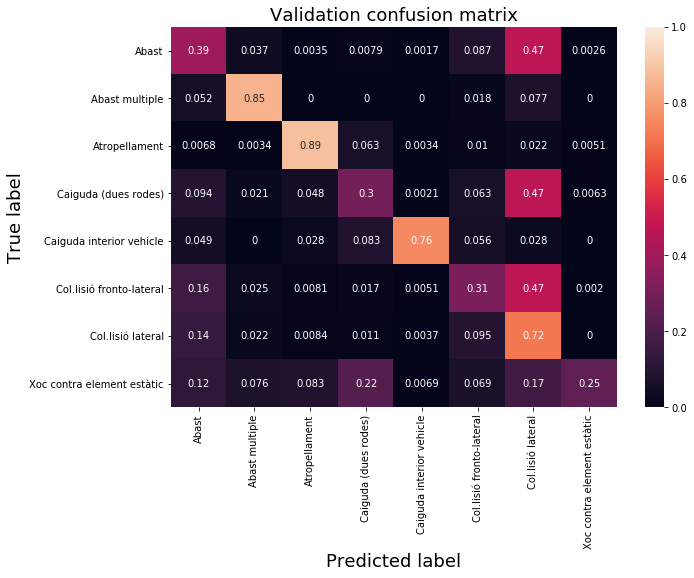

In [75]:
cm = confusion_matrix(ytest.values.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_norm, classes = feature_list,title='Validation confusion matrix')
plt.show()

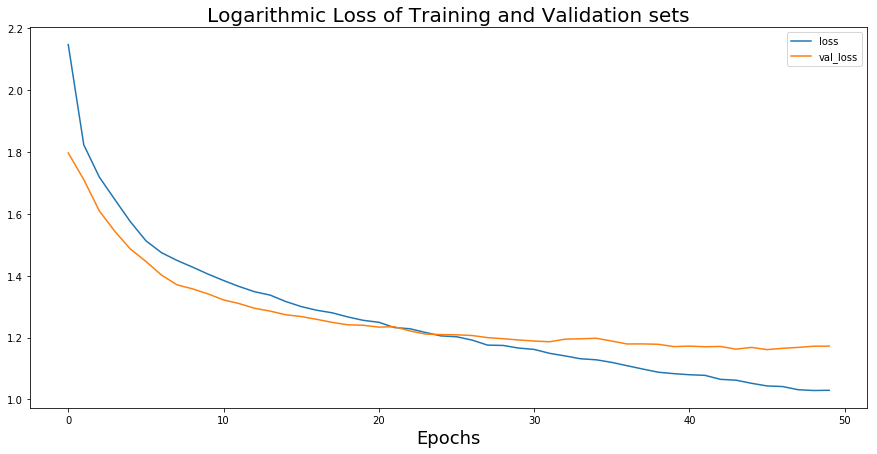

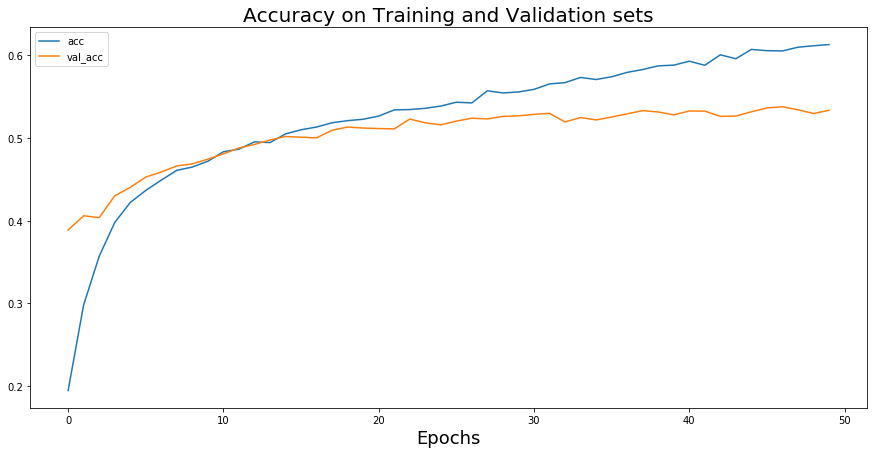

In [77]:
# plot some data
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['loss'], label='loss')
plt.plot(fited_model.history['val_loss'], label='val_loss')
plt.title('Logarithmic Loss of Training and Validation sets', fontsize=20)
plt.xlabel('Epochs', size=18)

plt.legend()
plt.show()

# accuracies
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['acc'], label='acc')
plt.plot(fited_model.history['val_acc'], label='val_acc')
plt.title('Accuracy on Training and Validation sets', fontsize=20)
plt.xlabel('Epochs', size=18)

plt.legend()
plt.show()